In [1]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

## Parameters for path generation

In [2]:
dis = 1.0
angle = 27
delta_angle = angle / 3
scale = 0.65


## Generating paths

In [7]:
path_start_all = []
path_all = []
path_list = []

path_id = 0
group_id = 0

for shift1 in np.arange(-angle, angle+0.1, delta_angle):
    waypts_start = np.array([[0, 0], [dis, shift1]])
    
    path_start_r = np.arange(0, dis+0.01, 0.01)
    cs_start = CubicSpline(waypts_start[:, 0], waypts_start[:, 1])
    path_start_shift = cs_start(path_start_r)
    
    path_start_x = path_start_r * np.cos(np.radians(path_start_shift))
    path_start_y = path_start_r * np.sin(np.radians(path_start_shift))
    path_start_z = np.zeros_like(path_start_x)
    
    path_start = np.column_stack((path_start_x, path_start_y, path_start_z, np.ones_like(path_start_x) * group_id))
    path_start_all.append(path_start)
    
    for shift2 in np.arange(-angle * scale + shift1, (angle * scale + shift1)+0.1, delta_angle*scale):
        for shift3 in np.arange(-angle * scale**2 + shift2, (angle * scale**2 + shift2)+0.1, delta_angle*scale**2):
            initial_waypts = np.column_stack((path_start_r, path_start_shift))
            additional_waypts = np.array([
                [2 * dis, shift2],
                [3 * dis - 0.001, shift3],
                [3 * dis, shift3]
            ])
            waypts = np.vstack((initial_waypts, additional_waypts))
            
            path_r = np.arange(0, waypts[-1, 0]+0.01, 0.01)
            cs = CubicSpline(waypts[:, 0], waypts[:, 1])
            path_shift = cs(path_r)
            
            path_x = path_r * np.cos(np.radians(path_shift))
            path_y = path_r * np.sin(np.radians(path_shift))
            path_z = np.zeros_like(path_x)
            path = np.column_stack((path_x, path_y, path_z, np.ones_like(path_x) * path_id, np.ones_like(path_x) * group_id))

            path_all.append(path)
            path_list.append([path_x[-1], path_y[-1], path_z[-1], path_id, group_id])
            # plt.plot(path_x, path_y)
            path_id += 1
    
    group_id += 1

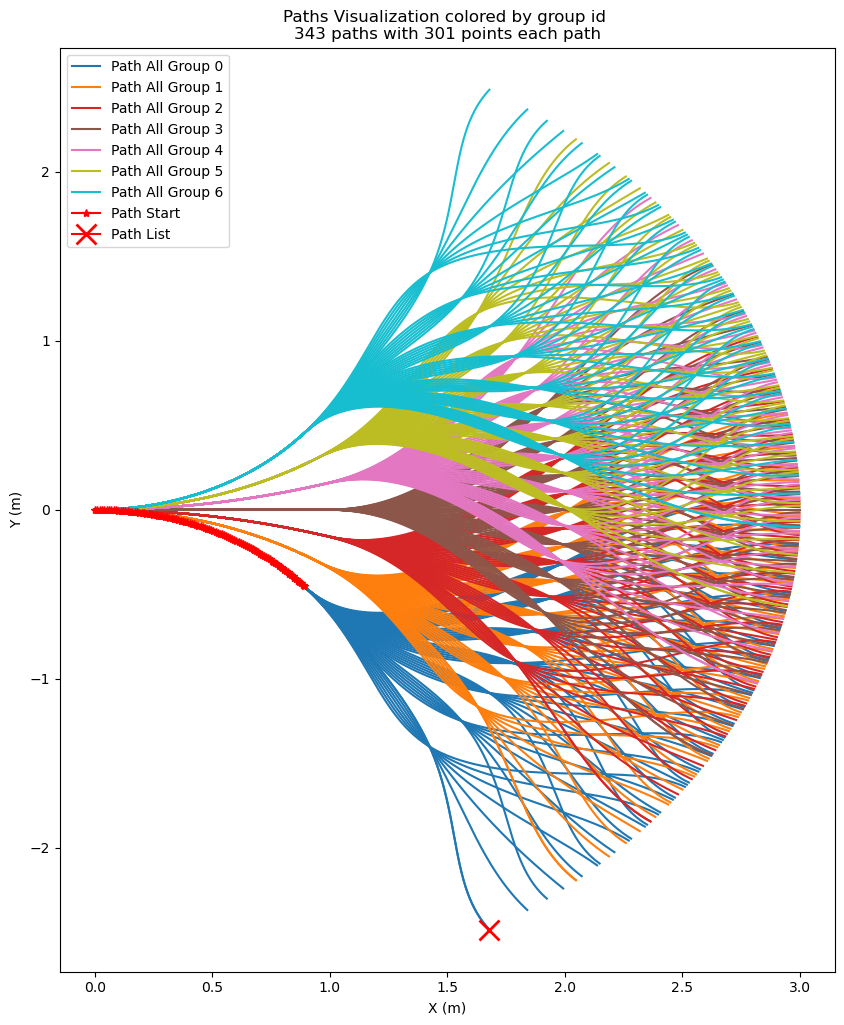

In [29]:
group_label = [0, 0, 0, 0, 0, 0, 0]
colors = plt.cm.tab10(np.linspace(0, 1, 7))
color_list = [tuple(color[:3]) for color in colors]

start_x = path_start_all[0]

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)

for path, path_l  in zip(path_all, path_list):
    if group_label[path_l[4]] == 0:
        ax.plot(path[:, 0], path[:, 1], color=color_list[path_l[4]], label=f"Path All Group {path_l[4]}")
        group_label[path_l[4]] = 1
    ax.plot(path[:, 0], path[:, 1], color=color_list[path_l[4]])
ax.plot(path_start_all[0][:, 0], path_start_all[0][:,1], marker='*', color='red', label='Path Start')
ax.plot(path_list[0][0], path_list[0][1], marker='x', color='red', markersize=15, markeredgewidth=2, label='Path List')

ax.set_title(f'Paths Visualization colored by group id \n{len(path_all)} paths with {len(path)} points each path')
ax.legend()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

## Parameters for patch matching and blocking
These parameters are also used in the local_planner node (TODO: make it read from a yaml file)

In [ ]:
voxel_size = 0.05
search_radius = 0.45
offset_x = 3.2
offset_y = 4.5
voxel_num_x = int((offset_x / voxel_size) + 1)
voxel_num_y = int(2 * (offset_y / voxel_size) + 1)

## Divide the space within the defined search area into voxels

In [ ]:
voxel_points = []
for ind_x in range(voxel_num_x):
    x = offset_x - voxel_size * ind_x
    scale_y = x / offset_x + search_radius / offset_y * (offset_x - x) / offset_x
    for ind_y in range(voxel_num_y):
        y = scale_y * (offset_y - voxel_size * ind_y)
        voxel_points.append([x, y])

voxel_points = np.array(voxel_points)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(voxel_points[:, 0], voxel_points[:, 1], np.zeros(len(voxel_points)))
ax.set_title(f'Voxel Points Visualization \n{len(voxel_points)} voxels')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

## Collision checking
1. For every points in the path, check whether there is any point next to it within the radius in the voxel points

In [ ]:
path_points = np.vstack([path[:, :2] for path in path_all])
np.shape(path_points)

In [ ]:
len(voxel_points)

In [ ]:

kdtree = cKDTree(path_points)
indices = kdtree.query_ball_point(voxel_points, search_radius)
indices

In [ ]:
len(indices)